## Aprendizado Não Supervisionado - Redução de Dimensionalidade
#### Prof. Thomas da Silva Paula

### PCA - Demo 3

* Utilização do algoritmo PCA antes de agrupamento de dados.
* Utilização do algoritmo GMM com diferentes parâmetros.
* Base de dados de descrição de vagas do Google - https://www.kaggle.com/niyamatalmass/google-job-skills

In [1]:
import time
import gensim
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500

sns.set(style='darkgrid', context='talk', rc={'figure.figsize': (14, 8)})

### Carregando a base de dados

In [9]:
df = pd.read_csv('../datasets/jobposts/job_skills.csv')
df.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expecta...","BA/BS degree or equivalent practical experience.\n3 years of experience in program and/or project management in cloud computing, enterprise software and/or marketing technologies.","Experience in the business technology market as a program manager in SaaS, cloud computing, and/or emerging technologies.\nSignificant cross-functional experience across engineering, sales, and marketing teams in cloud computing or related technical fields.\nProven successful program outcomes from idea to launch in multiple contexts throughout your career.\nAbility to manage the expectations, demands and priorities of multiple internal stakeholders based on overarching vision and success for..."
1,Google,"Supplier Development Engineer (SDE), Cable/Connector",Manufacturing & Supply Chain,"Shanghai, China","Drive cross-functional activities in the supply chain for overall Technical Operational readiness in all NPI phases leading into mass production.\nCollaborate with suppliers and Engineering teams in assessing process technologies based on project requirements, and propose and develop the manufacturing blueprint including process flow, equipment/fixture designs, implementation schedules and validation plans for engineering builds and mass production.\nDrive project technical and operational i...","BS degree in an Engineering discipline or equivalent practical experience.\n7 years of experience in Cable/Connector Design or Manufacturing in an NPI role.\nExperience working with Interconnect Engineering and Product Design (PD)/Mechanical Engineer in developing, manufacturing and testing.\nAbility to speak and write in English and Mandarin fluently and idiomatically.","BSEE, BSME or BSIE degree.\nExperience of using Statistics tools for Data analysis, e.g. distribution histogram/pareto chart, process control chart, Design of Experiment (DOE), Correlation Analysis, etc.\nDemonstrated knowledge in PCBA manufacturing process and quality control.\nFamilar with cable/connector related components' manufacturing: moldling, stamping, die-casting, LIM, MIM process and materials.\nSelf starter with innovation, integrity and attention to detail.\nAbility to travel up..."
2,Google,"Data Analyst, Product and Tools Operations, Google Technical Services",Technical Solutions,"New York, NY, United States","Collect and analyze data to draw insight and identify strategic solutions.\nBuild consensus by facilitating broad collaboration with clear communication and documentation.\nWork with cross-functional stakeholders to gather requirements, manage implementation, and drive delivery of projects.","Bachelor’s degree in Business, Economics, Statistics, Operations Research or related analytical field, or equivalent practical experience.\n2 years of work experience in business analysis.\n1 year of experience with statistical modeling, forecasting or machine learning. Experience with R, SAS or Python.\n1 year of experience developing and manipulating large datasets.",Experience partnering or consulting cross-functionally with senior stakeholders.\nProficiency in a database query language (e.g. SQL).\nAbility to manage multiple projects in an ambiguous environment.\nStrong presentation and communication skills with the ability to communicate statistical concepts and explain recommendations to non-experts.
3,Google,"Develop

In [10]:
print(len(df))

1250


### Removendo algumas colunas
Vamos manter a descrição da vaga para realizar o agrupamento de dados. Título e categoria serão mantidos para podermos avaliar os resultados.

In [11]:
columns_to_drop = ['Company', 'Location', 'Minimum Qualifications', 'Preferred Qualifications']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,Title,Category,Responsibilities
0,Google Cloud Program Manager,Program Management,"Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expecta..."
1,"Supplier Development Engineer (SDE), Cable/Connector",Manufacturing & Supply Chain,"Drive cross-functional activities in the supply chain for overall Technical Operational readiness in all NPI phases leading into mass production.\nCollaborate with suppliers and Engineering teams in assessing process technologies based on project requirements, and propose and develop the manufacturing blueprint including process flow, equipment/fixture designs, implementation schedules and validation plans for engineering builds and mass production.\nDrive project technical and operational i..."
2,"Data Analyst, Product and Tools Operations, Google Technical Services",Technical Solutions,"Collect and analyze data to draw insight and identify strategic solutions.\nBuild consensus by facilitating broad collaboration with clear communication and documentation.\nWork with cross-functional stakeholders to gather requirements, manage implementation, and drive delivery of projects."
3,"Developer Advocate, Partner Engineering",Developer Relations,"Work one-on-one with the top Android, iOS, and web engineers to build exciting new product/API integrations that drive adoption of Google’s developer platforms.\nConceive new features and ideas that can change how users interact with apps and Google, and help developers build them.\nConduct regular, engineering-focused meetings with developers to help them design new systems, fix bugs, improve UX, and solve complex code issues.\nWork on the source code of Google's products with other enginee..."
4,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Plan requirements with internal customers.\nProvide portfolio reports and forecasts to Regional Service Delivery Manager. Manage vendor PM services to usher projects through the entire lifecycle.\nPlan finances and tracking across a portfolio of projects.\nEnsure that any changes in scope, schedule or cost are managed in accordance with the agreed change order procedures. Interface with cross functional stakeholders to understand and communicate program strategy and priorities.\nEnsure proje..."


In [12]:
df.isna().sum()

Title                0
Category             0
Responsibilities    15
dtype: int64

### Pré-processamento

In [13]:
def preprocess_text(original_text, stops):
    
    text = str(original_text).lower()
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    filtered_words = [w for w in text.split() if w not in stops]
    text = ' '.join(filtered_words)
    
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    return text

In [14]:
stops = set(stopwords.words("english"))

In [15]:
df['processed_responsibilities'] = df['Responsibilities'].apply(lambda x: preprocess_text(x, stops))
df.head()

,Title,Category,Responsibilities,processed_responsibilities
0,Google Cloud Program Manager,Program Management,"Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expecta...",shape shepherd ship show technical programs designed support work cloud customer engineers solutions architects measure report key metrics tied programs identify need change course cancel scale programs regional global platform communicate status identify obstacles paths resolution stakeholders including senior roles transparent regular professional timely manner establish expectations rationale deliverables stakeholders program contributors provide program performance feedback teams product...
1,"Supplier Development Engineer (SDE), Cable/Connector",Manufacturing & Supply Chain,"Drive cross-functional activities in the supply chain for overall Technical Operational readiness in all NPI phases leading into mass production.\nCollaborate with suppliers and Engineering teams in assessing process technologies based on project requirements, and propose and develop the manufacturing blueprint including process flow, equipment/fixture designs, implementation schedules and validation plans for engineering builds and mass production.\nDrive project technical and operational i...",drive cross functional activities supply chain overall technical operational readiness npi phases leading mass production collaborate suppliers engineering teams assessing process technologies based project requirements propose develop manufacturing blueprint including process flow equipment fixture designs implementation schedules validation plans engineering builds mass production drive project technical operational issues material process fixtures equipment etc npi phase enable delivery m...
2,"Data Analyst, Product and Tools Operations, Google Technical Services",Technical Solutions,"Collect and analyze data to draw insight and identify strategic solutions.\nBuild consensus by facilitating broad collaboration with clear communication and documentation.\nWork with cross-functional stakeholders to gather requirements, manage implementation, and drive delivery of projects.",collect analyze data draw insight identify strategic solutions build consensus facilitating broad collaboration clear communication documentation work cross functional stakeholders gather requirements manage implementation drive delivery projects
3,"Developer Advocate, Partner Engineering",Developer Relations,"Work one-on-one with the top Android, iOS, and web engineers to build exciting new product/API integrations that drive adoption of Google’s developer platforms.\nConceive new features and ideas that can change how users interact with apps and Google, and help developers build them.\nConduct regular, engineering-focused meetings with developers to help them design new systems, fix bugs, improve UX, and solve complex code issues.\nWork on the source code of Google's products with other enginee...",work one on one top android ios web engineers build exciting new product api integrations drive adoption google’s developer platforms conceive new features ideas change users interact apps google help developers build them conduct regular engineering focused meetings developers help design new systems fix bugs improve ux solve complex code issues work source code google s products engineers identify reproduce and or fix bugs affecting developers
4,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Plan requirements with internal customers.\nProvide portfolio reports and fore

### Extração de features

In [16]:
vectorizer = TfidfVectorizer()

In [17]:
features = vectorizer.fit_transform(df['processed_responsibilities'])
features.shape

(1250, 3796)

## Testar GMM

In [18]:
def do_clustering(data, features, k=3, covariance_type='full', tol=0.001, 
                  max_iter=100, n_init=1, init_params='kmeans', random_state=133):
    
    data_copy = data.copy()
    model = GaussianMixture(n_components=k, covariance_type=covariance_type, tol=tol,
                            max_iter=max_iter, n_init=n_init, init_params=init_params, random_state=random_state)
    model.fit(features)
    cluster_labels = model.predict(features)
    
    data_copy['cluster_labels'] = cluster_labels
    return data_copy, cluster_labels

In [19]:
def show_cluster_data(data, cluster_id, top_k=10):
    return data[data['cluster_labels'] == cluster_id][['Title', 'Responsibilities']][:top_k]

In [20]:
def plot_titles_in_cluster(data, cluster_id, top_k=5):
    df_title = df_copy[data['cluster_labels'] == cluster_id]['Title'].value_counts().to_frame()
    df_title['Description'] = df_title.index
    df_title.reset_index(drop=True, inplace=True)
    df_title.rename(columns={'Title': 'Count'}, inplace=True)
    df_title.head()

    sns.barplot(x='Count', y='Description', data=df_title[:top_k].sort_values(by='Count', ascending=False))

### Experimento 1 - Sem PCA

In [21]:
print('Shape das features:', features.shape)

Shape das features: (1250, 3796)


In [22]:
start_time = time.time()

k = 10
df_copy, cluster_labels = do_clustering(df, features.toarray(), k)
df_copy.head()

print('Tempo de processamento:', time.time() - start_time)

Tempo de processamento: 110.2175543308258


Vamos pular a parte de exploração dos grupos aqui, pois já vimos no exemplo anterior do GMM

### Experimento 2 - Com PCA

#### Redução de dimensionalidade

Vamos aplicar PCA com o valor de 0.9, o que significa que serão mantidos componentes que correspondam a 90% da variância dos dados.

In [23]:
pca = PCA(n_components=0.9, random_state=133)
pca.fit(features.toarray())

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=133,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
print('Número de principal components:', len(pca.components_))

Número de principal components: 374


Efetuando a redução de dimensionalidade

In [25]:
features_reduced = pca.transform(features.toarray())
print('Shape das features reduzidas:', features_reduced.shape)

Shape das features reduzidas: (1250, 374)


#### Agrupamento de dados

In [26]:
start_time = time.time()

k = 10
df_copy, cluster_labels = do_clustering(df, features_reduced, k)
df_copy.head()

print('Tempo de processamento:', time.time() - start_time)

Tempo de processamento: 1.2475042343139648


### Inspecionando clusters

#### Quantidade de instâncias por cluster

<AxesSubplot:xlabel='clusters', ylabel='counts'>

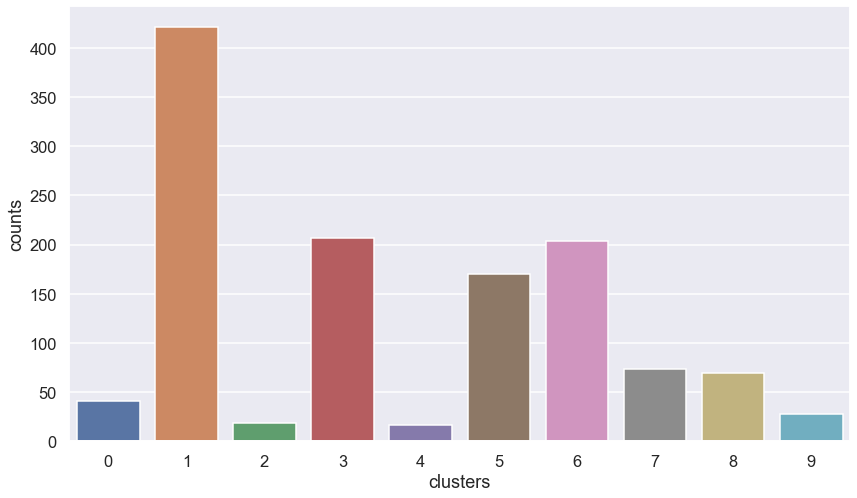

In [27]:
clusters, counts = np.unique(cluster_labels, return_counts=True)

clusters_df = pd.DataFrame()
clusters_df['clusters'] = clusters
clusters_df['counts'] = counts

sns.barplot(x='clusters', y='counts', data=clusters_df)

#### Mostrar instâncias de um cluster específico

In [28]:
show_cluster_data(df_copy, cluster_id=0, top_k=5)

,Title,Responsibilities
607,Business Intern 2018,"Responsibilities and detailed projects will be determined based on your educational background, interest and skills."
609,Business Intern 2018,"Responsibilities and detailed projects will be determined based on your educational background, interest and skills."
612,Business Intern 2018,"Responsibilities and detailed projects will be determined based on your educational background, interest and skills."
615,Business Intern 2018,"Responsibilities and detailed projects will be determined based on your educational background, interest and skills."
617,Business Intern 2018,"Responsibilities and detailed projects will be determined based on your educational background, interest and skills."


In [29]:
show_cluster_data(df_copy, cluster_id=7, top_k=5)

,Title,Responsibilities
9,"Solutions Architect, Healthcare and Life Sciences, Google Cloud","Help compile customer requirements as well as survey existing customer IT landscape to enable integrations from PoC stage to a full deployment of products managing healthcare and/or life sciences data in Google Cloud.\nDefine the business case for solutions, design solutions to help prototype and develop the customer’s new environment, and guide solutions through launch to market. Create training materials, guides, demonstrations and white papers and help scale solutions delivery.\nEngage st..."
14,"Solution Architect, Google Cloud Platform (Apigee)","Produce required design specifications, provide technical leadership and architectural mentorship and help customers build quality technical solutions/implementations with on-premises, cloud and hybrid cloud-based Apigee solution.\nWork closely with geographically distributed Apigee and Customer project teams to align the technical requirements and the solution design with the customer's business drivers and in order to demonstrate our value.\nAct as a liaison for the engineering and product..."
16,"Machine Learning Product Specialist, Google Cloud (EMEA)","Work as part of the Sales team to identify and qualify Platform opportunities and determine if Google Cloud Platform is right for them. Identify business and technical requirements, conduct full technical discovery and architect client solutions to meet gathered requirements.\nTake responsibility for leading the technical project, including such activities as technology advocacy, supporting bid responses, product and solution briefings, proof-of-concept work, and the coordination of supporti..."
25,"Partner Sales Engineer, Google Cloud","Work with Partner Managers to identify and recruit partners in the market that can deliver innovative solutions to our customers, built on top of Google Cloud (Google Cloud Platform and G Suite).\nDevelop our partners’ technical teams with both sales and technical competencies, so that they can be successful in the market.\nKeep partners up-to-date with product and technical knowledge and market differentiators.\nWork with partner technical representatives in opportunities and projects, comp..."
28,"Machine Learning Product Specialist, Google Cloud (EMEA)","Work as part of the Sales team to identify and qualify Platform opportunities and determine if Google Cloud Platform is right for them. Identify business and technical requirements, conduct full technical discovery and architect client solutions to meet gathered requirements.\nTake responsibility for leading the technical project, including such activities as technology advocacy, supporting bid responses, product and solution briefings, proof-of-concept work, and the coordination of supporti..."


#### Plotar títulos mais comuns de um cluster específico

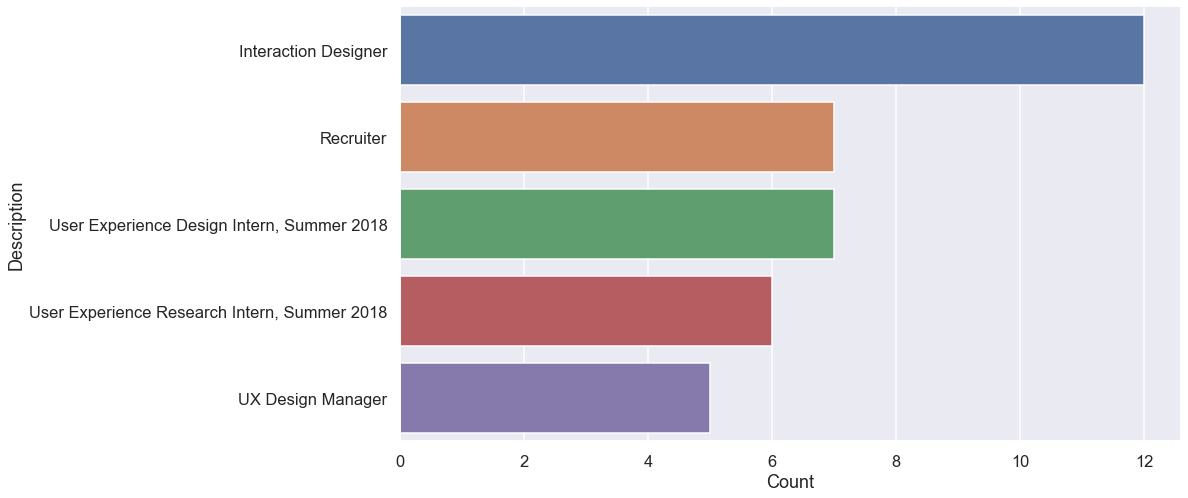

In [30]:
plot_titles_in_cluster(df_copy, cluster_id=1, top_k=5)

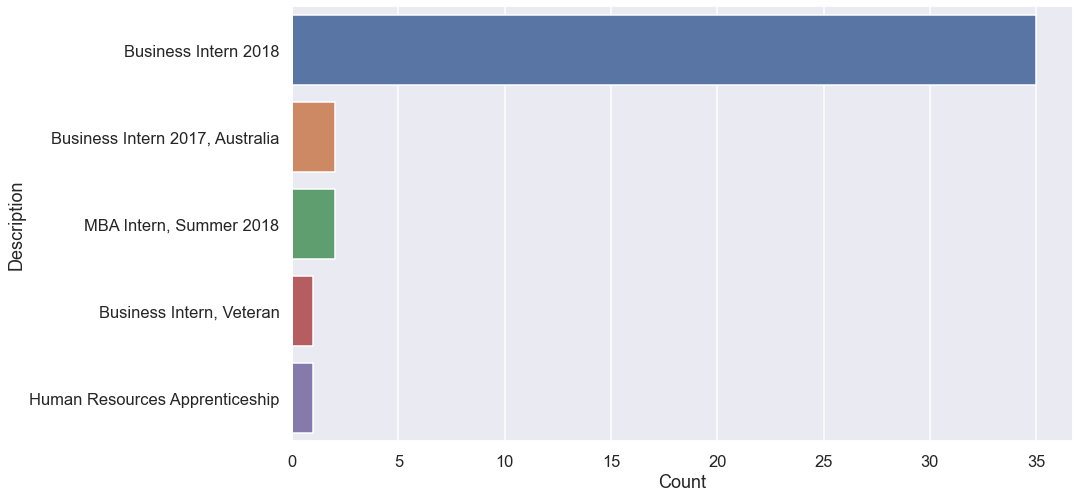

In [31]:
plot_titles_in_cluster(df_copy, cluster_id=0, top_k=5)

### Experimento 2

In [32]:
start_time = time.time()

k = 30
df_copy, cluster_labels = do_clustering(df, features_reduced, k)
df_copy.head()

print('Tempo de processamento:', time.time() - start_time)

Tempo de processamento: 3.8750808238983154


### Inspecionando clusters

#### Quantidade de instâncias por cluster

<AxesSubplot:xlabel='clusters', ylabel='counts'>

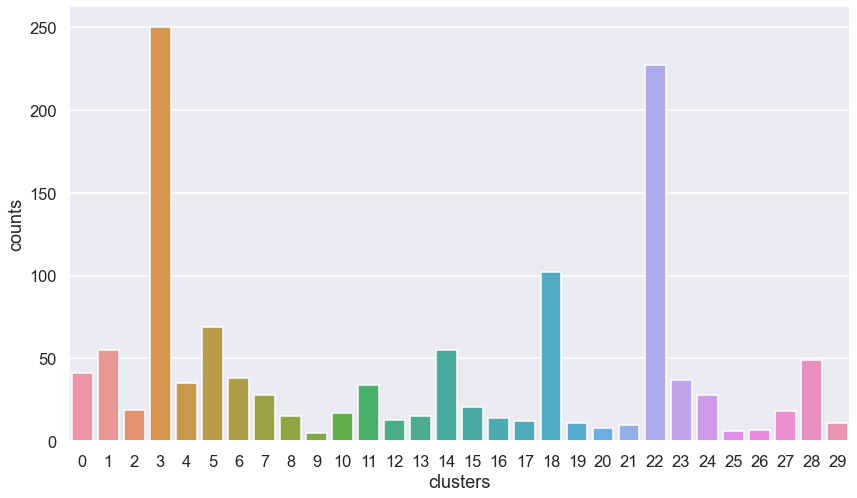

In [33]:
clusters, counts = np.unique(cluster_labels, return_counts=True)

clusters_df = pd.DataFrame()
clusters_df['clusters'] = clusters
clusters_df['counts'] = counts

sns.barplot(x='clusters', y='counts', data=clusters_df)

#### Mostrar instâncias de um cluster específico

In [34]:
show_cluster_data(df_copy, cluster_id=1, top_k=5)

,Title,Responsibilities
942,Accountant,"Manage month-end close activities by taking ownership and closely collaborating with regional teams; local accounting and the relevant GAAP reconciliations (between US GAAP and local China GAAP).\nManage statutory reporting, statistic filings, tax filings and other compliance requirements, and foreign exchange compliance.\nCollaborate with the central Treasury team and complete assigned tasks.\nCollaborate with other functions and regional teams on various projects upon request.\nInteract wi..."
943,"Internal Audit, Technology Auditor","Identify and call attention to financial, operational, compliance, and reputational risks through assurance, consulting, and solutions management activity; improving the effectiveness of Alphabet’s governance, risk management, and internal control activities.\nWork in cross-functional teams including Engineering, Product Management, Sales Operations and Finance to help create integrated system requirements and provide IT controls expertise.\nConceive and lead ad-hoc analyses of financial and..."
944,"Senior Technology Auditor, Internal Audit","Identify and call attention to financial, operational, compliance, and reputational risks through assurance, consulting, and solutions management activities. Improve the effectiveness of governance, risk management, and internal control activities.\nWork in cross-functional teams including Engineering, Product Management, Sales Operations and Finance to help create integrated system requirements and to provide IT controls expertise.\nInitiate and lead ad hoc analyses of financial and IT data..."
946,"Payroll Operations Controller, Financial Operations (English, Portuguese)","Support and provide oversight of the payroll operational process for Latin America, which currently consists of paying employees accurately and on-time, meeting all compliance obligations, and answering employee queries.\nPartner with key stakeholders to evaluate, research, and resolve complex compliance or longer-term operational challenges that arise in order to reduce risk and improve the customer experience.\nExecute tasks and controls; perform variance analysis to support payment approv..."
947,"Risk Advisor, YouTube","Partner closely with Product, Engineering, Operations and Business Development to effectively articulate and assess the Financial risks and returns of new business growth initiatives. Find practical, scalable solutions for growing YouTube’s products and commercial initiatives faster and more safely.\nPrioritize and implement necessary financial processes and controls to grow monetization and financial reporting infrastructure.\nDrive prioritization, alignment and implementation of YouTube le..."


#### Plotar títulos mais comuns de um cluster específico

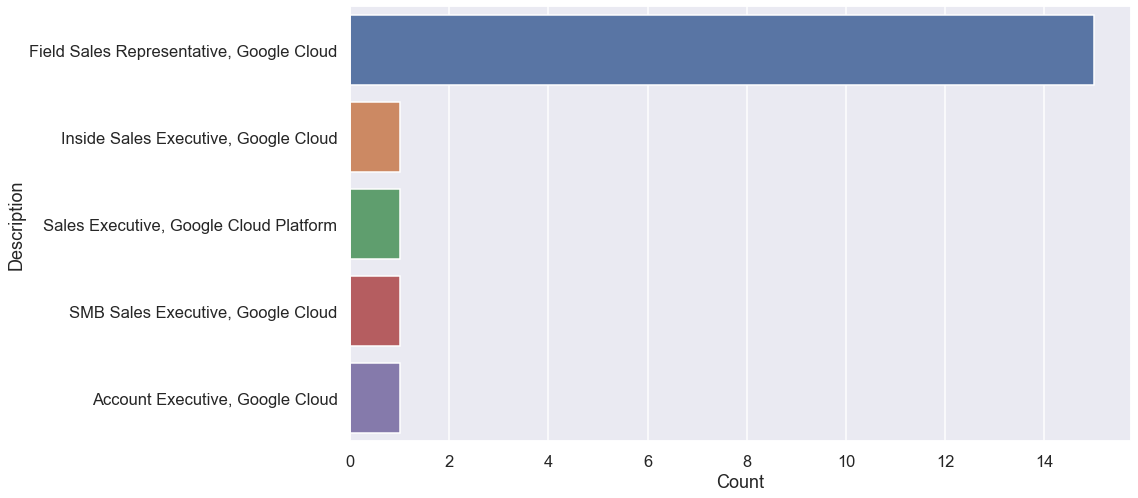

In [35]:
plot_titles_in_cluster(df_copy, cluster_id=2, top_k=5)

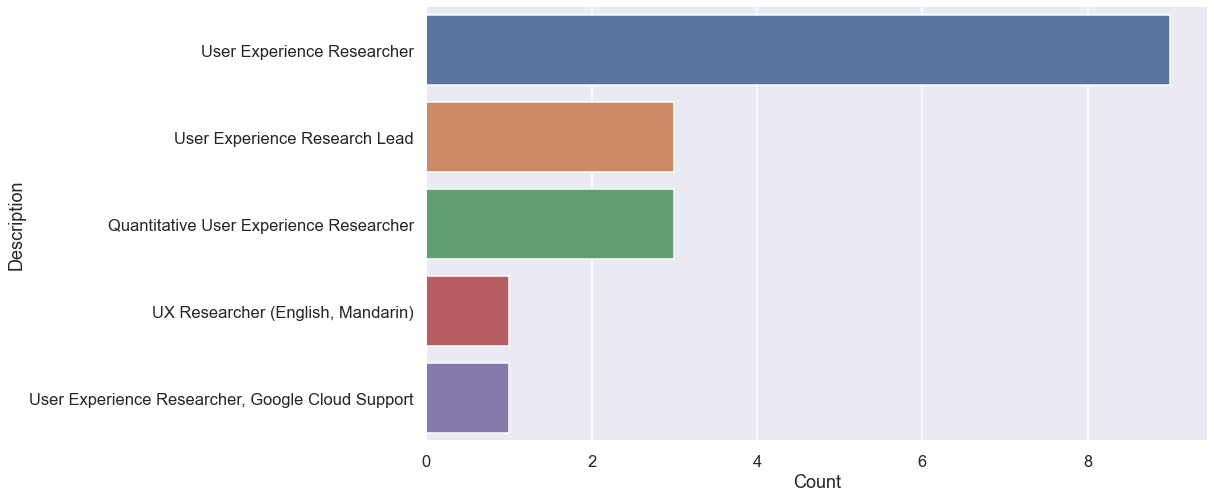

In [36]:
plot_titles_in_cluster(df_copy, cluster_id=10, top_k=5)

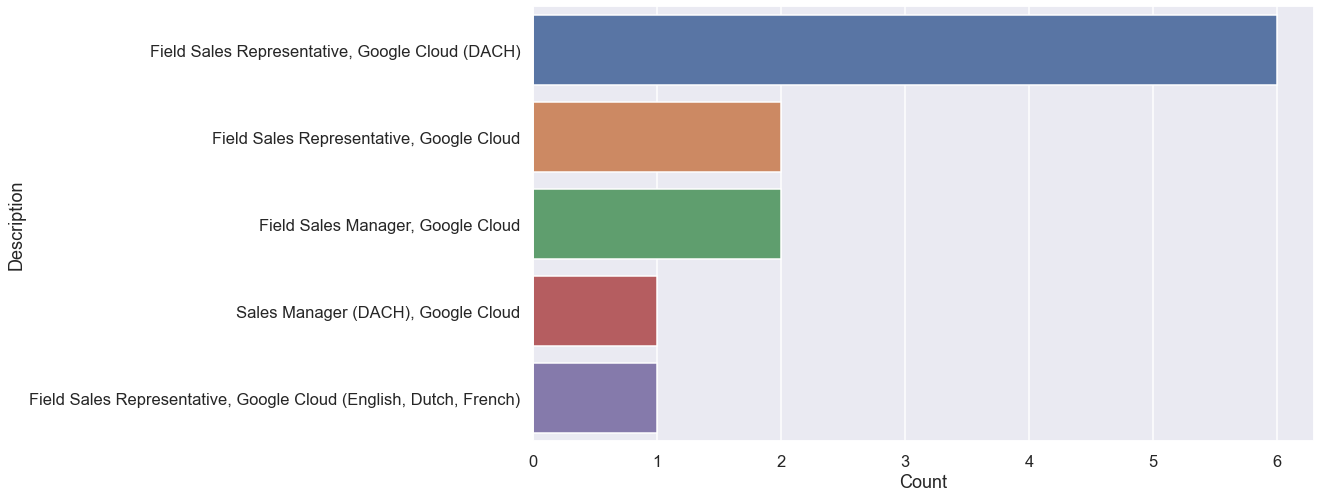

In [37]:
plot_titles_in_cluster(df_copy, cluster_id=17, top_k=5)

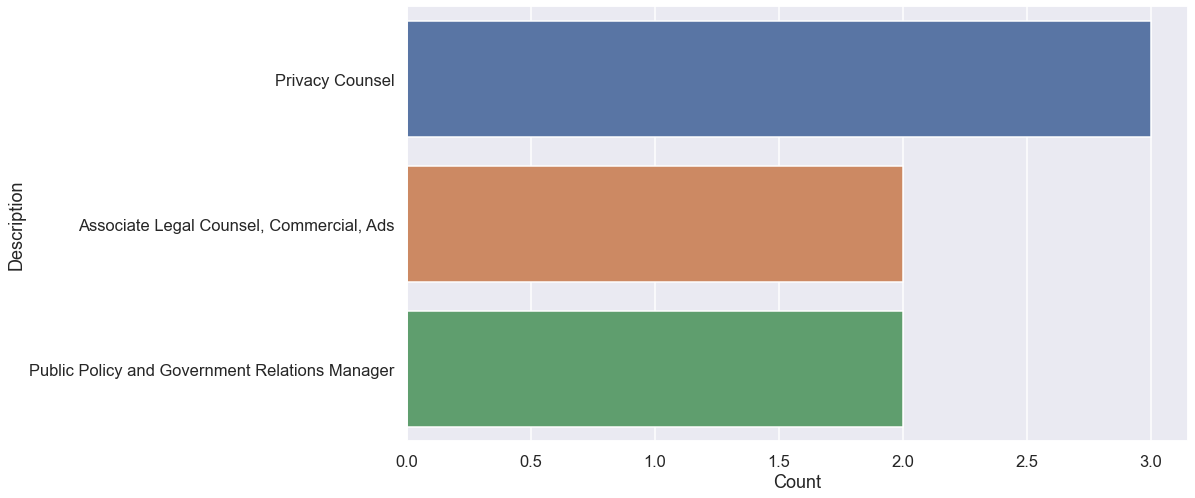

In [38]:
plot_titles_in_cluster(df_copy, cluster_id=24, top_k=3)